## Poisson VCM Results 

This notebook goes over the code needed to reproduce the results from the MSE and time figures for the Poisson base distribution with Log Link and covariance matrix $\Gamma$ structured under variance component model framework as follows:

$$
\Gamma = 0.05 * \mathbf{1_{n} 1_{n}^\top}
$$

In this example simulate three fixed effects under GLMM with $\beta \sim$ randn(Uniform(-0.2, 0.2), p) where p = 3 fixed effects.

We run each scenario 5 times and compare the run times of ours with that of GLMM's random intercept model from MixedModels.jl. 

In [30]:
versioninfo()

Julia Version 1.6.2
Commit 1b93d53fc4 (2021-07-14 15:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i9-9880H CPU @ 2.30GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, skylake)


In [31]:
using GLMCopula, DelimitedFiles, LinearAlgebra, Random, GLM
using Random, Roots, SpecialFunctions, DataFrames

In [32]:
p = 3    # number of fixed effects, including intercept
m = 1    # number of variance components
# true parameter values
Random.seed!(1234)
βtrue = rand(Uniform(-0.2, 0.2), p)
θtrue = [0.05]

# generate data
intervals = zeros(p + m, 2) #hold intervals
curcoverage = zeros(p + m) #hold current coverage resutls
trueparams = [βtrue; θtrue] #hold true parameters

#simulation parameters
samplesizes = [100; 1000; 10000; 100000]
ns = [2; 5; 10]
nsims = 5

5

In [35]:
cd("/Users/sarahji/.julia/dev/GLMCopula/sim_glmm_vs_ours_random_int/poisson_sim_glmm")

In [36]:
@info "reading in the files with results"
βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
fittimes_QC = vec(readdlm("fittimes_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

┌ Info: reading in the files with results
└ @ Main In[36]:1


60-element Vector{Float64}:
  0.023319893
  0.025191819
  0.028104155
  0.022595776
  0.026170402
  0.026398217
  0.023732461
  0.030037977
  0.024221401
  0.021428809
  0.028979834
  0.02687747
  0.026289609
  ⋮
 16.386620975
 28.811331751
 11.24830771
  7.896102991
 23.784640952
 17.425656309
 19.266263612
 19.023016978
 35.197617755
 54.81468283
 34.030964458
 37.28575035

In [37]:
fittimes_GLMM = vec(readdlm("fittimes_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

60-element Vector{Float64}:
   0.276911223
   0.020874351
   0.046466525
   0.015009406
   0.019675201
   0.08308952
   0.110808557
   0.04062093
   0.084917644
   0.047001313
   0.128564867
   0.123648207
   0.14328125
   ⋮
  17.916392865
  24.351682286
  82.587550855
  78.088277766
  74.758043842
  83.524162156
  91.163996903
 180.796040829
 195.018021061
 208.935284905
 297.879679375
 111.632507804

In [45]:
#simulation parameters
@info "making results table Quasi-Copula"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_QC)
timedf1 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf1, Dict(:fittimes_function => "se"))
timedf1[!, :nobs] = Meta.parse.(timedf1[!, :samplesize]) .* Meta.parse.(timedf1[!, :obssize])
timedf1[!, :fitmin] = timedf1[!, :fittime] - timedf1[!, :se]
timedf1[!, :fitmax] = timedf1[!, :fittime] + 2 * timedf1[!, :se]
timedf1[!, :perobsratio] = timedf1[!, :fittime] ./ timedf1[!, :nobs]
timedf1[!, 1:4]

┌ Info: making results table Quasi-Copula
└ @ Main In[45]:2


,samplesize,obssize,fittime,se
,String,String,Float64,Float64
1,100,2,0.0250764,0.00099036
2,100,5,0.0251638,0.00145204
3,100,10,0.0293764,0.00154984
4,1000,2,0.0637476,0.0037765
5,1000,5,0.0839639,0.00875163
6,1000,10,0.125812,0.00595204
7,10000,2,0.94729,0.122173
8,10000,5,1.28443,0.247586
9,10000,10,2.00762,0.348481


In [48]:
#simulation parameters
@info "making results table GLMM"
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))

msedf = DataFrame(samplesize = sample_sizes, obssize = obs_sizes, fittimes = fittimes_GLMM)
timedf2 = combine(groupby(msedf, [:samplesize, :obssize]), :fittimes => mean => :fittime,
    :fittimes => x -> (std(x)/sqrt(length(x))))
rename!(timedf2, Dict(:fittimes_function => "se"))
timedf2[!, :nobs] = Meta.parse.(timedf2[!, :samplesize]) .* Meta.parse.(timedf2[!, :obssize])
timedf2[!, :fitmin] = timedf2[!, :fittime] - timedf2[!, :se]
timedf2[!, :fitmax] = timedf2[!, :fittime] + timedf2[!, :se]
timedf2[!, :perobsratio] = timedf2[!, :fittime] ./ timedf2[!, :nobs]
timedf2
timedf2[!, 1:4]

┌ Info: making results table GLMM
└ @ Main In[48]:2


,samplesize,obssize,fittime,se
,String,String,Float64,Float64
1,100,2,0.0757873,0.0505809
2,100,5,0.0732876,0.0130331
3,100,10,0.139382,0.00564954
4,1000,2,0.249717,0.0279564
5,1000,5,0.647529,0.0268909
6,1000,10,1.32919,0.0662903
7,10000,2,2.84266,0.19021
8,10000,5,7.34857,0.851689
9,10000,10,19.0859,1.2233


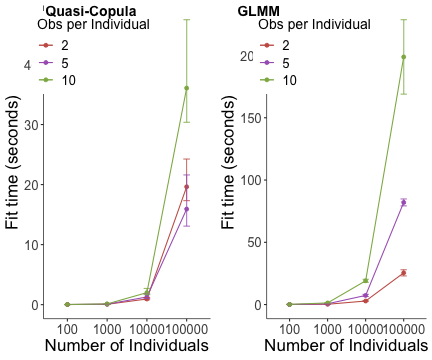

RObject{VecSxp}


In [40]:
########### plot the runtimes
using RCall
@rput timedf1
@rput timedf2
R"""
library(ggplot2)
library(cowplot)
timedf1$obssize = factor(timedf1$obssize, levels = c('2', '5', '10'))
timedf1$samplesize = factor(timedf1$samplesize, levels = c('100', '1000', '10000', '100000'))

fittime_1 = ggplot(timedf1, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

timedf2$obssize = factor(timedf2$obssize, levels = c('2', '5', '10'))
timedf2$samplesize = factor(timedf2$samplesize, levels = c('100', '1000', '10000', '100000'))

fittime_2 = ggplot(timedf2, aes(x = samplesize, y = fittime, group = obssize, color = obssize)) + 
  geom_line() +
  geom_point()+
  geom_errorbar(aes(ymin=fitmin, ymax=fitmax), width=0.5, alpha = 0.8, position=position_dodge(0.005)) + 
  theme(legend.position=c(0.3,0.85), legend.key = element_blank(), axis.text.x = element_text(angle=0, size=13),
        axis.text.y = element_text(angle=0, size=13), axis.title.x = element_text(size = 17), 
        axis.title.y = element_text(size = 17), legend.title = element_text(size = 14),
        #axis.ticks = element_blank(),
        panel.grid.major = element_blank(), legend.text=element_text(size=13),
        panel.border = element_blank(), panel.grid.minor = element_blank(), panel.background = element_blank(), 
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5)) + 
   scale_color_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
  labs(x = "Number of Individuals", y = "Fit time (seconds)", color = "Obs per Individual")

fittime_nsamples = plot_grid(fittime_1, fittime_2, labels = c("Quasi-Copula", "GLMM"))
"""

In [9]:
R"""
ggsave('sim_glmm_fittime_nsamples_poisson_vs_glmm.png', fittime_nsamples, width = 15, height = 17, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_fittime_nsamples_poisson_vs_glmm.png"


In [49]:
######  supplementary table s1
using Random, DataFrames, DelimitedFiles, Statistics
import StatsBase: sem

βθcoverage = readdlm("beta_sigma_coverage_multivariate_poisson_vcm$(nsims)reps_sim.csv", ',')

m  = 1

covdf = DataFrame(Matrix(transpose(βθcoverage)), :auto)
rename!(covdf, Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]]))
covdf[!, :samplesize] = sample_sizes
covdf[!, :obssize] = obs_sizes
first(covdf, 10)

row_stats = [[(mean(col), sem(col)) for col = eachcol(d[!, 1:end-2])] for d = groupby(covdf, [:samplesize; :obssize])]
df = DataFrame(row_stats, :auto)
ss_obs = unique("N: " .* sample_sizes .* "  ni: " .* obs_sizes)
rename!(df, Symbol.(ss_obs))
covdfdisplay = DataFrame([[names(df)]; collect.(eachrow(df))], 
    [:people_obs; Symbol.([["β$i" for i in 1:p]; ["θ$i" for i in 1:m]])])
# deletecols!(covdfdisplay, p + 2)
covdfdisplay


,people_obs,β1,β2,β3,θ1
,String,Tuple…,Tuple…,Tuple…,Tuple…
1,N: 100 ni: 2,"(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)","(1.0, 0.0)"
2,N: 100 ni: 5,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
3,N: 100 ni: 10,"(0.4, 0.244949)","(1.0, 0.0)","(0.6, 0.244949)","(0.6, 0.244949)"
4,N: 1000 ni: 2,"(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)"
5,N: 1000 ni: 5,"(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)"
6,N: 1000 ni: 10,"(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)","(1.0, 0.0)"
7,N: 10000 ni: 2,"(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)","(0.8, 0.2)"
8,N: 10000 ni: 5,"(0.8, 0.2)","(0.8, 0.2)","(1.0, 0.0)","(0.4, 0.244949)"
9,N: 10000 ni: 10,"(0.8, 0.2)","(0.6, 0.244949)","(0.8, 0.2)","(0.2, 0.2)"


In [50]:
#### 
#import data and reorganize to create figure
using Random, DataFrames, DelimitedFiles, Statistics, RCall, Printf
import StatsBase: sem

βMseresult = vec(readdlm("mse_beta_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult = vec(readdlm("mse_Sigma_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))

βMseresult_GLMM = vec(readdlm("mse_beta_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))
θMseresult_GLMM = vec(readdlm("mse_Sigma_GLMM_multivariate_poisson_vcm$(nsims)reps_sim.csv", ','))


p = 3; m = 1
sample_sizes = repeat(string.(samplesizes), inner = nsims * length(ns))
obs_sizes = repeat(string.(ns), inner = nsims, outer = length(samplesizes))
msedf1 = DataFrame(βmse = βMseresult, thetamse = θMseresult, 
    samplesize = sample_sizes, obssize = obs_sizes)

msedf2 = DataFrame(βmse = βMseresult_GLMM, thetamse = θMseresult_GLMM, 
    samplesize = sample_sizes, obssize = obs_sizes)

#rename to make parsing easier for R.

msedf1 = deepcopy(msedf1)
rename!(msedf1, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

msedf2 = deepcopy(msedf2)
rename!(msedf2, ["betamse"
    "thetamse"
    "samplesize"
 "obssize"]);

mses = [msedf1[!, :betamse]; msedf1[!, :thetamse]; msedf2[!, :betamse]; msedf2[!, :thetamse]]
    # msedfnormR[!, :betamse]; msedfnormR[!, :taumse]; msedfnormR[!, :Sigmamse]]
obssize = [collect([repeat(msedf1[!, :obssize], 2)]...) ; collect([repeat(msedf2[!, :obssize], 2)]...)]
#40
samplesize = [collect([repeat(msedf1[!, :samplesize], 2)]...) ; collect([repeat(msedf2[!, :samplesize], 2)]...)]

parameters = [collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...) ; collect([repeat(string.([:beta, :theta]), inner = nsims * length(ns) * length(samplesizes))]...)]
robust = [collect([repeat(["Poisson Quasi-Copula"], 2 * nsims * length(ns) * length(samplesizes))]...); collect([repeat(["Poisson GLMM"],  2 * nsims * length(ns) * length(samplesizes))]...)]

msedfR = DataFrame(mse = mses, obssize = obssize, samplesize = samplesize,
    parameters = parameters, robust = robust)

#5 of the 30,000 simulations did not converge, filter out
msedfR = filter(x -> !isnan(x.mse), msedfR)
# additionally, there are 5 where an error was not caught so it did not try a differnt solver
msedfR = filter(x -> x.mse < 40000, msedfR)

,mse,obssize,samplesize,parameters,robust
,Float64,String,String,String,String
1,0.0022147,2,100,beta,Poisson Quasi-Copula
2,0.00245313,2,100,beta,Poisson Quasi-Copula
3,0.00284419,2,100,beta,Poisson Quasi-Copula
4,0.00328039,2,100,beta,Poisson Quasi-Copula
5,0.00516435,2,100,beta,Poisson Quasi-Copula
6,0.000970534,5,100,beta,Poisson Quasi-Copula
7,0.000714614,5,100,beta,Poisson Quasi-Copula
8,0.00147628,5,100,beta,Poisson Quasi-Copula
9,0.00488136,5,100,beta,Poisson Quasi-Copula


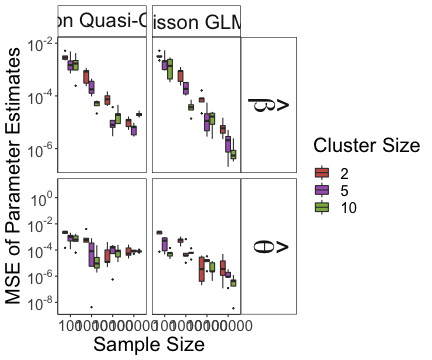

RObject{VecSxp}


In [51]:
### working on figure next
@rput msedfR

R"""
library(scales)
library(ggplot2)
library(data.table)

msedfR = data.table(msedfR)

msedfR[parameters == "beta",y_min := 10^-4]
msedfR[parameters == "beta",y_max := 10^-2]
msedfR[parameters == "theta",y_min := 10^-5]
msedfR[parameters == "theta",y_max := 10^1]

#msedfR[parameters == "beta",y_min := 10^-8]
#msedfR[parameters == "beta",y_max := 10^-2]
#msedfR[parameters == "tau",y_min := 10^-8]
#msedfR[parameters == "tau",y_max := 10^-2]
#msedfR[parameters == "Sigma",y_min := 10^-5]
#msedfR[parameters == "Sigma",y_max := 10^-2]


msedfR$obssize = factor(msedfR$obssize, levels = c('2', '5', '10'))
msedfR$samplesize = factor(msedfR$samplesize, levels = c('100', '1000', '10000', '100000'))
msedfR$parameters = factor(msedfR$parameters, levels = c('beta', 'theta'), labels = c(beta = expression(hat(bold(beta))), thetaa = expression(hat(bold(theta))[])))
msedfR$robust <- factor(msedfR$robust, levels = c('Poisson Quasi-Copula', 'Poisson GLMM'),
    labels = c(expression(paste("Poisson Quasi-Copula")), expression(paste("Poisson GLMM"))))


#mseplot <- ggplot(msedfR[msedfR$mse < 10^0, ], aes(x=samplesize, y=mse, fill=obssize)) + 
mseplot = ggplot(msedfR[msedfR$mse < 10^3, ], aes(x=samplesize, y=mse, fill=obssize)) + 
  #geom_boxplot(outlier.size = 0.0, outlier.alpha = 0) +
  geom_boxplot(outlier.size = 0.25) +
#    geom_violin() +
    facet_grid(parameters ~ robust, labeller = label_parsed, scales = "free_y") +
  theme(legend.position="right", legend.key = element_blank(), axis.text.x = element_text(angle=0, size=15),
        axis.text.y = element_text(angle=0, size=15), axis.title.x = element_text(size = 20), 
        axis.title.y = element_text(size = 20), legend.title = element_text(size = 20),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.text=element_text(size=15), panel.background = element_rect(fill = NA, color = "black"),
        #panel.background = element_blank(), #panel.border = element_blank(),
        axis.line = element_line(color = 'black',size=0.3), plot.title = element_text(hjust = 0.5),
        strip.background = element_rect(colour="black", fill="white"), strip.text.y = element_text(size=30, face="bold"),
        strip.text.x = element_text(size=20)) + 
  scale_fill_manual(values = c("#c85f55",
"#a964bf",
"#8db352",
"#fa7300",
"#05aec0",
"#ff1493")) +
#scale_y_log10(breaks = scales::trans_breaks("log10", function(x) 10^x)) +
#scale_y_log10(breaks = 10^(-8:8), limit=c(10^-8, 10^2)) + 
scale_y_log10(breaks = 10^seq(-10, 10, 2), labels=trans_format("log10", math_format(10^.x))) + #, limit=c(10^-8, 10^2)) +
  labs(x = "Sample Size", y = "MSE of Parameter Estimates", fill = "Cluster Size") +
geom_blank(aes(y = y_max)) + 
geom_blank(aes(y = y_min)) 

"""

In [13]:
R"""
ggsave('sim_glmm_updated_msefacetplot_poisson.png', mseplot, width = 12.5, height = 15, units = 'in', dpi = 450)
"""

RObject{StrSxp}
[1] "sim_glmm_updated_msefacetplot_poisson.png"
